In [1]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style('whitegrid')

sys.path.append("../")
from utility.hmm1 import HMM1
from utility.hmmar1 import HMMAR1, HMMAR1GibbsSampler

In [2]:
# Synthetic Data

# grouth truth
phi = 0.99
s = 1
v = s * (1 - phi**2)
w = s
hmm_sim = HMM1(phi, v, w_var=w)

# simulated series
np.random.seed(23502938)
df = hmm_sim.simulate(0, 1000)

In [2]:
# SOI Data
soi = pd.read_table("../data/soi.txt", names=['soi']).soi

In [3]:
# initialize
sampler = HMMAR1GibbsSampler(
    ys = soi,
    priors=HMMAR1GibbsSampler.Priors(
        mu0=0, mu_var=5,
        w0=1, w_ddof=9,
        phi0=0.5, phi_var=5, phi_bound=(0, 1),
        v0=1, v_ddof=9,
    ),
)

x0 = HMMAR1.LatentState(0, 1)

In [4]:
posterior_samples = sampler.sample_posterior(x0, n_samples=5000, burnin=1000)
# posterior_samples = sampler.sample_posterior(x0, n_samples=5000, theta=posterior_samples[-1].para)

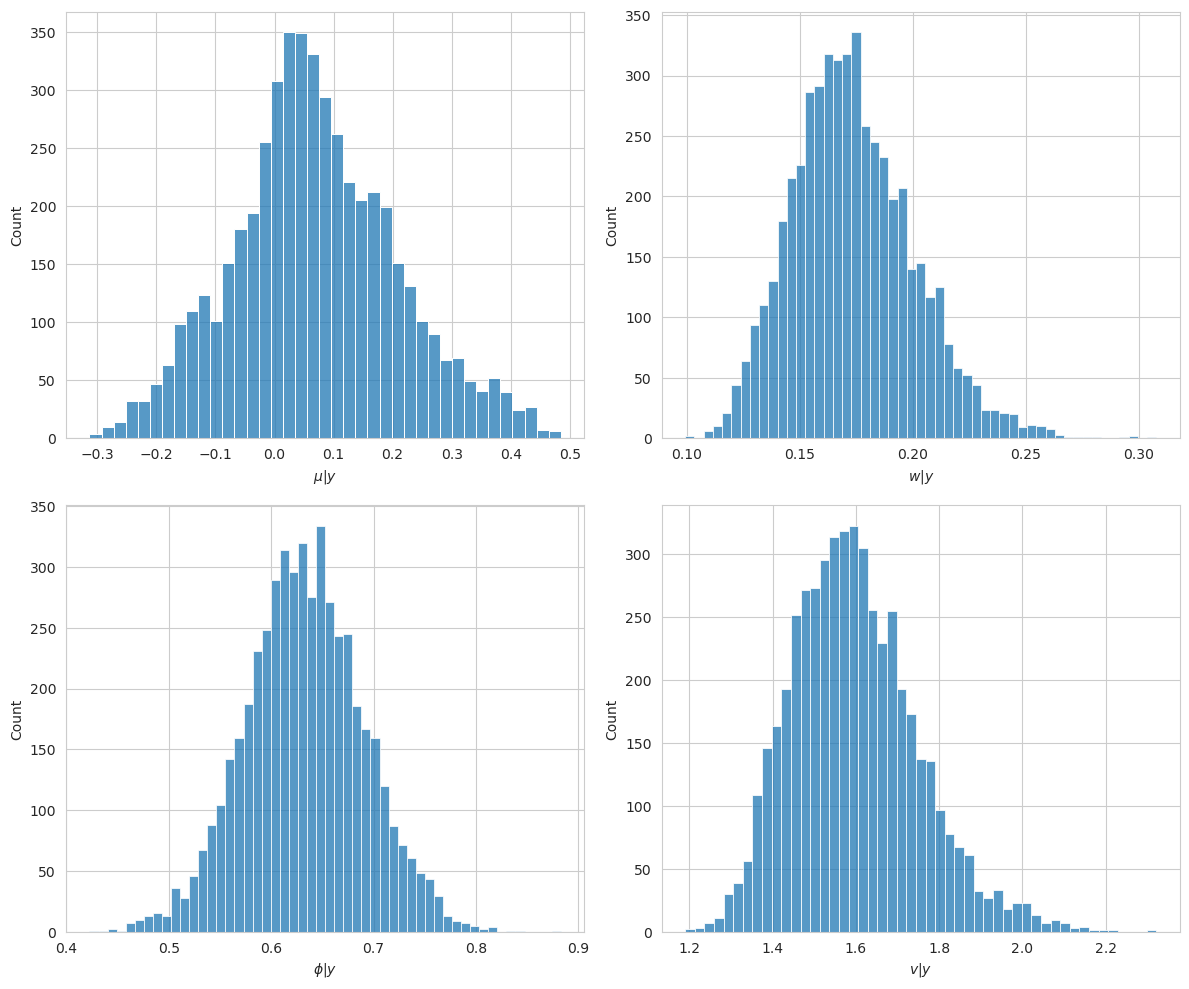

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sns.histplot(pd.Series(map(lambda x: x[0].mu, posterior_samples)), ax=ax[0, 0])
sns.histplot(pd.Series(map(lambda x: x[0].wt, posterior_samples)), ax=ax[0, 1])
sns.histplot(pd.Series(map(lambda x: x[0].phi, posterior_samples)), ax=ax[1,0])
sns.histplot(pd.Series(map(lambda x: x[0].v, posterior_samples)), ax=ax[1, 1])

ax[0,0].set_xlabel('$\\mu|y$')
ax[0,1].set_xlabel('$w|y$')
ax[1,0].set_xlabel('$\\phi|y$')
ax[1,1].set_xlabel('$v|y$')

fig.tight_layout()
fig.show()

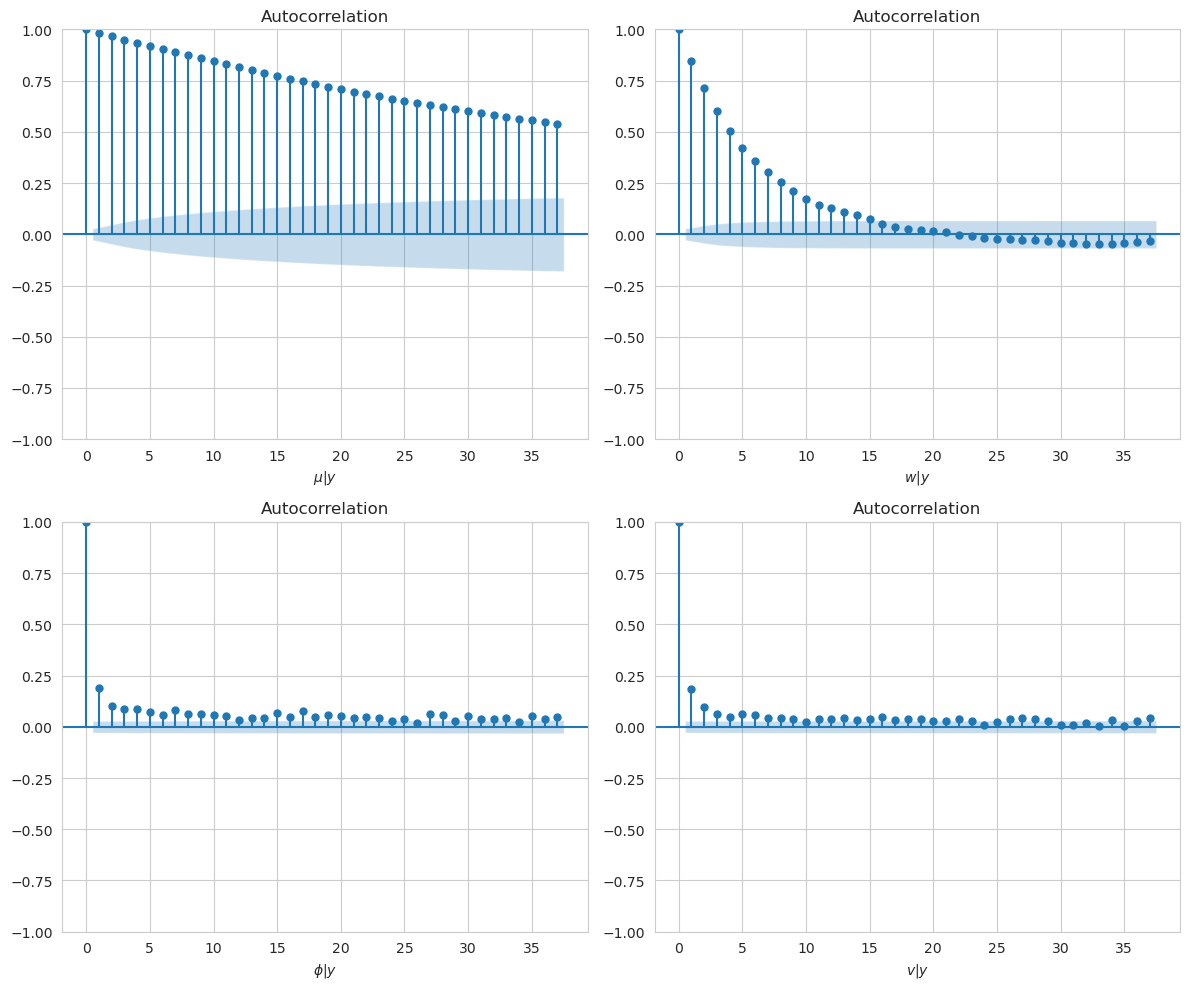

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[0].mu, posterior_samples)), ax=ax[0,0])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[0].wt, posterior_samples)), ax=ax[0,1])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[0].phi, posterior_samples)), ax=ax[1,0])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[0].v, posterior_samples)), ax=ax[1,1])

ax[0,0].set_xlabel('$\\mu|y$')
ax[0,1].set_xlabel('$w|y$')
ax[1,0].set_xlabel('$\\phi|y$')
ax[1,1].set_xlabel('$v|y$')

fig.tight_layout()
fig.show()

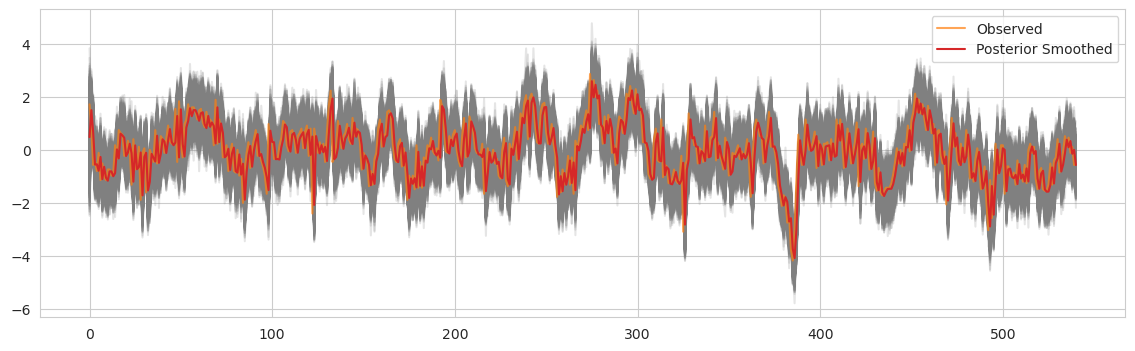

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.array(list(map(lambda x: x[1], posterior_samples))).T, alpha=0.2, color='grey')
ax.plot(soi, alpha=0.7, color=sns.color_palette()[1], label='Observed')
ax.plot(np.array(list(map(lambda x: x[1], posterior_samples))).T.mean(1), color=sns.color_palette()[3], label='Posterior Smoothed')
plt.legend()